# DMRG and TEBD algorithms

References:
- J. C. Bridgeman, C. T. Chubb  
  Hand-waving and interpretive dance: An introductory course on tensor networks  
  [J. Phys. A: Math. Theor. 50 223001 (2017)](https://doi.org/10.1088/1751-8121/aa6dc3) ([arXiv:1603.03039](https://arxiv.org/abs/1603.03039))
- U. Schollwöck  
  The density-matrix renormalization group in the age of matrix product states  
  [Ann. Physics 326, 96-192 (2011)](https://doi.org/10.1016/j.aop.2010.09.012) ([arXiv:1008.3477](https://arxiv.org/abs/1008.3477))

In [1]:
import numpy as np
from scipy.linalg import expm
from scipy import sparse
import scipy.sparse.linalg as scila
from copy import deepcopy
import matplotlib.pyplot as plt

## Utility functions

In [2]:
def crandn(size):
    """
    Draw random samples from the standard complex normal (Gaussian) distribution.
    """
    # 1/sqrt(2) is a normalization factor
    return (np.random.normal(size=size) + 1j*np.random.normal(size=size)) / np.sqrt(2)

In [3]:
def retained_bond_indices(s, tol):
    """
    Indices of retained singular values based on given tolerance.
    """
    w = np.linalg.norm(s)
    if w == 0:
        return np.array([], dtype=int)
    # normalized squares
    s = (s / w)**2
    # accumulate values from smallest to largest
    sort_idx = np.argsort(s)
    s[sort_idx] = np.cumsum(s[sort_idx])
    return np.where(s > tol)[0]

In [4]:
def split_matrix_svd(A, tol):
    """
    Split a matrix by singular value decomposition,
    and truncate small singular values based on tolerance.
    """
    assert A.ndim == 2
    u, s, v = np.linalg.svd(A, full_matrices=False)
    # truncate small singular values
    idx = retained_bond_indices(s, tol)
    u = u[:, idx]
    v = v[idx, :]
    s = s[idx]
    return u, s, v

## MPS class and related utility functions

In [5]:
def local_orthonormalize_left_qr(A, Anext):
    """
    Left-orthonormalize a MPS tensor `A` by a QR decomposition,
    and update tensor at next site.
    """
    # perform QR decomposition and replace A by reshaped Q matrix
    s = A.shape
    assert len(s) == 3
    Q, R = np.linalg.qr(np.reshape(A, (s[0]*s[1], s[2])), mode='reduced')
    A = np.reshape(Q, (s[0], s[1], Q.shape[1]))
    # update Anext tensor: multiply with R from left
    Anext = np.transpose(np.tensordot(R, Anext, (1, 1)), (1, 0, 2))
    return A, Anext

In [6]:
def local_orthonormalize_right_qr(A, Aprev):
    """
    Right-orthonormalize a MPS tensor `A` by a QR decomposition,
    and update tensor at previous site.
    """
    # flip left and right virtual bond dimensions
    A = np.transpose(A, (0, 2, 1))
    # perform QR decomposition and replace A by reshaped Q matrix
    s = A.shape
    assert len(s) == 3
    Q, R = np.linalg.qr(np.reshape(A, (s[0]*s[1], s[2])), mode='reduced')
    A = np.transpose(np.reshape(Q, (s[0], s[1], Q.shape[1])), (0, 2, 1))
    # update Aprev tensor: multiply with R from right
    Aprev = np.tensordot(Aprev, R, (2, 1))
    return A, Aprev

In [7]:
def merge_mps_tensor_pair(A0, A1):
    """
    Merge two neighboring MPS tensors.
    """
    A = np.tensordot(A0, A1, (2, 1))
    # pair original physical dimensions of A0 and A1
    A = A.transpose((0, 2, 1, 3))
    # combine original physical dimensions
    A = A.reshape((A.shape[0]*A.shape[1], A.shape[2], A.shape[3]))
    return A

In [8]:
class MPS(object):
    """
    Matrix product state (MPS) class.

    The i-th MPS tensor has dimension `[d, D[i], D[i+1]]` with `d` the physical
    dimension at each site and `D` the list of virtual bond dimensions.
    """

    def __init__(self, d, D, fill='zero'):
        """
        Create a matrix product state.
        """
        self.d = d
        # leading and trailing bond dimensions must agree (typically 1)
        assert D[0] == D[-1]
        if fill == 'zero':
            self.A = [np.zeros((d, D[i], D[i+1])) for i in range(len(D)-1)]
        elif fill == 'random real':
            # random real entries
            self.A = [np.random.normal(size=(d, D[i], D[i+1])) / np.sqrt(d*D[i]*D[i+1]) for i in range(len(D)-1)]
        elif fill == 'random complex':
            # random complex entries
            self.A = [crandn(size=(d, D[i], D[i+1])) / np.sqrt(d*D[i]*D[i+1]) for i in range(len(D)-1)]
        else:
            raise ValueError('fill = {} invalid.'.format(fill))

    @property
    def local_dim(self):
        """Local (physical) dimension at each lattice site."""
        return self.d

    @property
    def nsites(self):
        """Number of lattice sites."""
        return len(self.A)

    @property
    def bond_dims(self):
        """Virtual bond dimensions."""
        if len(self.A) == 0:
            return []
        else:
            D = [self.A[i].shape[1] for i in range(len(self.A))]
            D.append(self.A[-1].shape[2])
            return D

    @property
    def dtype(self):
        """Data type of tensor entries."""
        return self.A[0].dtype

    def orthonormalize(self, mode='left'):
        """Left- or right-orthonormalize the MPS using QR decompositions."""
        if len(self.A) == 0:
            return

        if mode == 'left':
            for i in range(len(self.A) - 1):
                self.A[i], self.A[i+1] = local_orthonormalize_left_qr(self.A[i], self.A[i+1])
            # last tensor
            self.A[-1], T = local_orthonormalize_left_qr(self.A[-1], np.array([[[1.0]]]))
            # normalization factor (real-valued since diagonal of R matrix is real)
            assert T.shape == (1, 1, 1)
            nrm = T[0, 0, 0].real
            if nrm < 0:
                # flip sign such that normalization factor is always non-negative
                self.A[-1] = -self.A[-1]
                nrm = -nrm
            return nrm
        elif mode == 'right':
            for i in reversed(range(1, len(self.A))):
                self.A[i], self.A[i-1] = local_orthonormalize_right_qr(self.A[i], self.A[i-1])
            # first tensor
            self.A[0], T = local_orthonormalize_right_qr(self.A[0], np.array([[[1.0]]]))
            # normalization factor (real-valued since diagonal of R matrix is real)
            assert T.shape == (1, 1, 1)
            nrm = T[0, 0, 0].real
            if nrm < 0:
                # flip sign such that normalization factor is always non-negative
                self.A[0] = -self.A[0]
                nrm = -nrm
            return nrm
        else:
            raise ValueError('mode = {} invalid; must be "left" or "right".'.format(mode))

    def as_vector(self):
        """Merge all tensors to obtain the vector representation on the full Hilbert space."""
        psi = self.A[0]
        for i in range(1, len(self.A)):
            psi = merge_mps_tensor_pair(psi, self.A[i])
        assert psi.ndim == 3
        # contract leftmost and rightmost virtual bond (has no influence if these virtual bond dimensions are 1)
        psi = np.trace(psi, axis1=1, axis2=2)
        return psi

In [9]:
def split_mps_tensor(A, d0, d1, svd_distr, tol=0):
    """
    Split a MPS tensor with dimension `d0*d1 x D0 x D2` into two MPS tensors
    with dimensions `d0 x D0 x D1` and `d1 x D1 x D2`, respectively.
    """
    assert A.ndim == 3
    assert d0 * d1 == A.shape[0], 'physical dimension of MPS tensor must be equal to d0 * d1'
    # reshape as matrix and split by SVD
    A = np.transpose(np.reshape(A, (d0, d1, A.shape[1], A.shape[2])), (0, 2, 1, 3))
    s = A.shape
    A0, sigma, A1 = split_matrix_svd(A.reshape((s[0]*s[1], s[2]*s[3])), tol)
    A0.shape = (s[0], s[1], len(sigma))
    A1.shape = (len(sigma), s[2], s[3])
    # use broadcasting to distribute singular values
    if svd_distr == 'left':
        A0 = A0 * sigma
    elif svd_distr == 'right':
        A1 = A1 * sigma[:, None, None]
    elif svd_distr == 'sqrt':
        s = np.sqrt(sigma)
        A0 = A0 * s
        A1 = A1 * s[:, None, None]
    else:
        raise ValueError('svd_distr parameter must be "left", "right" or "sqrt".')
    # move physical dimension to the front
    A1 = A1.transpose((1, 0, 2))
    return A0, A1

In [10]:
def is_left_orthonormal(A):
    """
    Test whether a MPS tensor `A` is left-orthonormal.
    """
    s = A.shape
    assert len(s) == 3
    A = np.reshape(A, (s[0]*s[1], s[2]))
    return np.allclose(A.conj().T @ A, np.identity(s[2]))

In [11]:
def is_right_orthonormal(A):
    """
    Test whether a MPS tensor `A` is right-orthonormal.
    """
    # call `is_left_orthonormal` with flipped left and right virtual bond dimensions
    return is_left_orthonormal(np.transpose(A, (0, 2, 1)))

## MPO class and related utility functions

In [12]:
def merge_mpo_tensor_pair(A0, A1):
    """
    Merge two neighboring MPO tensors.
    """
    A = np.tensordot(A0, A1, (3, 2))
    # pair original physical dimensions of A0 and A1
    A = np.transpose(A, (0, 3, 1, 4, 2, 5))
    # combine original physical dimensions
    A = A.reshape((A.shape[0]*A.shape[1], A.shape[2]*A.shape[3], A.shape[4], A.shape[5]))
    return A

In [13]:
class MPO(object):
    """
    Matrix product operator (MPO) class.

    The i-th MPO tensor has dimension `[d, d, D[i], D[i+1]]` with `d` the physical
    dimension at each site and `D` the list of virtual bond dimensions.
    """

    def __init__(self, Alist):
        """
        Create a matrix product operator.
        """
        self.A = [np.array(Aj) for Aj in Alist]
        # consistency checks
        for i in range(len(self.A)-1):
            assert self.A[i].ndim == 4
            assert self.A[i].shape[3] == self.A[i+1].shape[2]
        assert self.A[0].shape[2] == self.A[-1].shape[3]

    @property
    def nsites(self):
        """Number of lattice sites."""
        return len(self.A)

    @property
    def bond_dims(self):
        """Virtual bond dimensions."""
        if len(self.A) == 0:
            return []
        else:
            D = [self.A[i].shape[2] for i in range(len(self.A))]
            D.append(self.A[-1].shape[3])
            return D

    def as_matrix(self):
        """Merge all tensors to obtain the matrix representation on the full Hilbert space."""
        op = self.A[0]
        for i in range(1, len(self.A)):
            op = merge_mpo_tensor_pair(op, self.A[i])
        assert op.ndim == 4
        # contract leftmost and rightmost virtual bond (has no influence if these virtual bond dimensions are 1)
        op = np.trace(op, axis1=2, axis2=3)
        return op

## Transverse-field Ising model

### Construct Ising Hamiltonian as MPO

In [14]:
def construct_ising_hamiltonian_mpo(J, g, L, pbc=False):
    """
    Construct Ising Hamiltonian on a 1D lattice with `L` sites as MPO,
    for interaction parameter `J` and external field parameter `g`.
    """
    # Pauli-X and Z matrices
    X = np.array([[0., 1.], [1.,  0.]])
    Z = np.array([[1., 0.], [0., -1.]])
    I = np.identity(2)
    O = np.zeros((2, 2))
    A = np.array([[I, O, O], [Z, O, O], [-g*X, -J*Z, I]])
    # flip the ordering of the virtual bond dimensions and physical dimensions
    A = np.transpose(A, (2, 3, 0, 1))
    if pbc:
        # periodic boundary conditions:
        # add a direct transition b -> a which applies -J Z at the rightmost lattice site
        AL = np.array([[-g*X, -J*Z, I], [Z, O, O]])
        AR = np.array([[I, -J*Z], [Z, O], [-g*X, O]])
        # flip the ordering of the virtual bond dimensions and physical dimensions
        AL = np.transpose(AL, (2, 3, 0, 1))
        AR = np.transpose(AR, (2, 3, 0, 1))
        return MPO([AL if i == 0 else A if i < L-1 else AR for i in range(L)])
    else:
        return MPO([A[:, :, 2:3, :] if i == 0 else A if i < L-1 else A[:, :, :, 0:1] for i in range(L)])

### Construct Ising Hamiltonian as sparse matrix (for comparison and testing)

In [15]:
def adjacency_1D_lattice(L, pbc=True):
    """
    Construct the adjacency matrix for a 1D lattice with `L` sites.
    The optional parameter `pbc` specifies whether periodic boundary conditions
    should be used.
    """
    assert L > 1
    # special case
    if L == 2:
        return np.array([[0, 1], [1, 0]])
    if pbc:
        # periodic boundary conditions
        return np.roll(np.identity(L, dtype=int), -1, axis=0) + np.roll(np.identity(L, dtype=int), 1, axis=0)
    else:
        # open boundary conditions
        return np.diag(np.ones(L - 1, dtype=int), k=-1) + np.diag(np.ones(L - 1, dtype=int), k=1)

In [16]:
# should be symmetric
np.linalg.norm(adjacency_1D_lattice(6) - adjacency_1D_lattice(6).T)

0.0

In [17]:
# each site should have 2 neighbors (for periodic boundary conditions)
np.sum(adjacency_1D_lattice(6), axis=0)

array([2, 2, 2, 2, 2, 2])

In [18]:
# example
adjacency_1D_lattice(6, pbc=False)

array([[0, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 1, 0, 1, 0, 0],
       [0, 0, 1, 0, 1, 0],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 1, 0]])

In [19]:
def construct_ising_hamiltonian_sparse(J, g, adj):
    """
    Construct Ising Hamiltonian as sparse matrix,
    for interaction parameter `J` and external field parameter `g`.
    `adj` is the adjacency matrix of the underlying lattice.
    """
    # Pauli-X and Z matrices
    X = sparse.csr_matrix([[0., 1.], [1.,  0.]])
    Z = sparse.csr_matrix([[1., 0.], [0., -1.]])
    # overall number of lattice sites
    L = adj.shape[0]
    H = sparse.csr_matrix((2**L, 2**L), dtype=float)
    for j in range(L):
        for k in range(j+1, L):
            if adj[j, k] > 0:
                H -= J * sparse.kron(sparse.eye(2**j),
                         sparse.kron(Z,
                         sparse.kron(sparse.eye(2**(k-j-1)),
                         sparse.kron(Z,
                                     sparse.eye(2**(L-k-1))))))
    # external field
    for j in range(L):
        H -= g * sparse.kron(sparse.eye(2**j), sparse.kron(X, sparse.eye(2**(L-j-1))))
    return H

In [20]:
# example
Hising_sparse = construct_ising_hamiltonian_sparse(1.1, 0.7, adjacency_1D_lattice(6, pbc=False))
Hising_sparse

<64x64 sparse matrix of type '<class 'numpy.float64'>'
	with 448 stored elements in Compressed Sparse Row format>

In [21]:
# convert to NumPy array to show entries
Hising_sparse.toarray()

array([[-5.5, -0.7, -0.7, ...,  0. ,  0. ,  0. ],
       [-0.7, -3.3,  0. , ...,  0. ,  0. ,  0. ],
       [-0.7,  0. , -1.1, ...,  0. ,  0. ,  0. ],
       ...,
       [ 0. ,  0. ,  0. , ..., -1.1,  0. , -0.7],
       [ 0. ,  0. ,  0. , ...,  0. , -3.3, -0.7],
       [ 0. ,  0. ,  0. , ..., -0.7, -0.7, -5.5]])

In [22]:
# compare (difference should be zero)
np.linalg.norm(Hising_sparse - construct_ising_hamiltonian_mpo(1.1, 0.7, 6).as_matrix())

0.0

In [23]:
# compare for periodic boundary conditions (difference should be zero)
np.linalg.norm(construct_ising_hamiltonian_sparse(1.1, 0.7, adjacency_1D_lattice(6, pbc=True)) - construct_ising_hamiltonian_mpo(1.1, 0.7, 6, pbc=True).as_matrix())

0.0

### Construct Ising Hamiltonian as sum of local interaction terms (for TEBD)

In [24]:
def construct_ising_hamiltonian_local_terms(J, g, L):
    """
    Construct Ising Hamiltonian on a one-dimensional lattice
    with open boundary conditions as sum of local interaction terms,
    for interaction parameter `J` and external field parameter `g`.
    """
    # Pauli-X and Z matrices
    X = np.array([[0., 1.], [1.,  0.]])
    Z = np.array([[1., 0.], [0., -1.]])
    I = np.identity(2)
    return [-J*np.kron(Z, Z) - g*(np.kron(X, I) + 0.5*np.kron(I, X)) if i == 0 else
            -J*np.kron(Z, Z) - g*0.5*(np.kron(X, I) + np.kron(I, X)) if i < L-2 else
            -J*np.kron(Z, Z) - g*(0.5*np.kron(X, I) + np.kron(I, X))
                for i in range(L-1)]

In [25]:
# example
hloc = construct_ising_hamiltonian_local_terms(1.1, 0.7, 6)
hloc

[array([[-1.1 , -0.35, -0.7 , -0.  ],
        [-0.35,  1.1 , -0.  , -0.7 ],
        [-0.7 , -0.  ,  1.1 , -0.35],
        [-0.  , -0.7 , -0.35, -1.1 ]]),
 array([[-1.1 , -0.35, -0.35, -0.  ],
        [-0.35,  1.1 , -0.  , -0.35],
        [-0.35, -0.  ,  1.1 , -0.35],
        [-0.  , -0.35, -0.35, -1.1 ]]),
 array([[-1.1 , -0.35, -0.35, -0.  ],
        [-0.35,  1.1 , -0.  , -0.35],
        [-0.35, -0.  ,  1.1 , -0.35],
        [-0.  , -0.35, -0.35, -1.1 ]]),
 array([[-1.1 , -0.35, -0.35, -0.  ],
        [-0.35,  1.1 , -0.  , -0.35],
        [-0.35, -0.  ,  1.1 , -0.35],
        [-0.  , -0.35, -0.35, -1.1 ]]),
 array([[-1.1 , -0.7 , -0.35, -0.  ],
        [-0.7 ,  1.1 , -0.  , -0.35],
        [-0.35, -0.  ,  1.1 , -0.7 ],
        [-0.  , -0.35, -0.7 , -1.1 ]])]

In [26]:
# for testing: construct overall sparse matrix representation of H from local terms
Hloc = sparse.csr_matrix((2**6, 2**6), dtype=float)
for j in range(6-1):
    Hloc += sparse.kron(sparse.eye(2**j),
            sparse.kron(hloc[j],
                        sparse.eye(2**(6-j-2))))

In [27]:
# compare (difference should be zero)
np.linalg.norm(Hising_sparse.toarray() - Hloc)

0.0

## Core DMRG algorithm

In [28]:
def contract_left_block(A, W, L):
    """
    Contraction step from left to right, with a matrix product operator
    sandwiched in between.

    To-be contracted tensor network::

      _________           _____
     /         \         /     \
     |        0|---   ---|1 A 2|---
     |         |         \__0__/
     |         |            |
     |         |
     |         |          __|__
     |         |         /  1  \
     |    L   1|---   ---|2 W 3|---
     |         |         \__0__/
     |         |            |
     |         |
     |         |          __|__
     |         |         /  0  \
     |        2|---   ---|1 A*2|---
     \_________/         \_____/
    """

    assert A.ndim == 3
    assert W.ndim == 4
    assert L.ndim == 3

    # multiply with conjugated A tensor
    T = np.tensordot(L, A.conj(), axes=(2, 1))

    # multiply with W tensor
    T = np.tensordot(W, T, axes=((0, 2), (2, 1)))

    # multiply with A tensor
    Lnext = np.tensordot(A, T, axes=((0, 1), (0, 2)))

    return Lnext

In [29]:

def contract_right_block(A, W, R):
    """
    Contraction step from right to left, with a matrix product operator
    sandwiched in between.

    To-be contracted tensor network::

          _____           _________
         /     \         /         \
      ---|1 A 2|---   ---|0        |
         \__0__/         |         |
            |            |         |
                         |         |
          __|__          |         |
         /  1  \         |         |
      ---|2 W 3|---   ---|1   R    |
         \__0__/         |         |
            |            |         |
                         |         |
          __|__          |         |
         /  0  \         |         |
      ---|1 A*2|---   ---|2        |
         \_____/         \_________/
    """

    assert A.ndim == 3
    assert W.ndim == 4
    assert R.ndim == 3

    # multiply with A tensor
    T = np.tensordot(A, R, 1)

    # multiply with W tensor
    T = np.tensordot(W, T, axes=((1, 3), (0, 2)))

    # interchange levels 0 <-> 2 in T
    T = T.transpose((2, 1, 0, 3))

    # multiply with conjugated A tensor
    Rnext = np.tensordot(T, A.conj(), axes=((2, 3), (0, 2)))

    return Rnext

In [30]:
def compute_right_operator_blocks(psi, op):
    """
    Compute all partial contractions from the right.
    """
    L = psi.nsites
    assert L == op.nsites
    BR = [None for _ in range(L)]
    # initialize rightmost dummy block
    BR[-1] = np.array([[[1]]], dtype=psi.dtype)
    for i in reversed(range(L-1)):
        BR[i] = contract_right_block(psi.A[i+1], op.A[i+1], BR[i+1])
    return BR

In [31]:
def construct_local_two_site_hamiltonian(V, W, L, R):
    """
    Construct the two-site local Hamiltonian operator.

    To-be contracted tensor network (the indices at the open legs
    show the ordering for the output tensor of degree 8)::

                    6       4               5        7
      _________     |       |               |        |    _________
     /         \    |       |               |        |   /         \
     |        0|---/        |               |        \---|0        |
     |         |            |               |            |         |
     |         |            |               |            |         |
     |         |            |               |            |         |
     |         |          __|__           __|__          |         |
     |         |         /  1  \         /  1  \         |         |
     |    L   1|---   ---|2 V 3|---   ---|2 W 3|---   ---|1   R    |
     |         |         \__0__/         \__0__/         |         |
     |         |            |               |            |         |
     |         |            |               |            |         |
     |         |            |               |            |         |
     |         |            |               |            |         |
     |        2|---\        |               |        /---|2        |
     \_________/    |       |               |       |    \_________/
                    |       |               |       |
                    2       0               1       3
    """
    # repeated indices are summed over
    return np.einsum(V, (0, 1, 2, 3), W, (4, 5, 3, 6), L, (7, 2, 8), R, (9, 6, 10), (0, 4, 8, 10, 1, 5, 7, 9))

In [32]:
def dmrg_two_site(H:MPO, psi:MPS, numsweeps, tol=1e-5):
    """
    Approximate the ground state MPS by left and right sweeps and local two-site optimizations.

    Args:
        H: Hamiltonian as MPO
        psi: initial MPS used for optimization; will be overwritten
        numsweeps: maximum number of left and right sweeps
        tol: "tolerance" for SVD truncation

    Returns:
        numpy.ndarray: array of approximate ground state energies after each iteration
    """

    # number of lattice sites
    L = H.nsites
    assert L == psi.nsites

    # right-normalize input matrix product state
    psi.orthonormalize(mode='right')

    # left and right operator blocks
    # initialize leftmost block by 1x1x1 identity
    BR = compute_right_operator_blocks(psi, H)
    BL = [None for _ in range(L)]
    BL[0] = np.array([[[1.0]]], dtype=BR[0].dtype)

    en_min = np.zeros(numsweeps)

    # Number of iterations should be determined by tolerance and some convergence measure
    for n in range(numsweeps):
        en = 0

        # sweep from left to right (rightmost two lattice sites are handled by right-to-left sweep)
        for i in range(L - 2):
            Hloc = construct_local_two_site_hamiltonian(H.A[i], H.A[i+1], BL[i], BR[i+1])
            s = Hloc.shape
            assert s[0] == s[1] == psi.local_dim
            assert s[4] == s[5] == psi.local_dim
            # reshape into a matrix
            Hloc = np.reshape(Hloc, (s[0]*s[1]*s[2]*s[3], s[4]*s[5]*s[6]*s[7]))
            # The following can be accelerated by Krylov methods and a "matrix free" application of the local Hamiltonian.
            wloc, vloc = np.linalg.eigh(Hloc)
            # select first eigenvector corresponding to lowest energy
            en = wloc[0]
            # optimized local tensor for two sites
            Aloc = np.reshape(vloc[:, 0], (s[0]*s[1], s[2], s[3]))
            psi.A[i], psi.A[i+1] = split_mps_tensor(Aloc, psi.local_dim, psi.local_dim, "right", tol)
            assert is_left_orthonormal(psi.A[i])
            # update the left blocks
            BL[i+1] = contract_left_block(psi.A[i], H.A[i], BL[i])

        # sweep from right to left
        for i in reversed(range(L - 1)):
            Hloc = construct_local_two_site_hamiltonian(H.A[i], H.A[i+1], BL[i], BR[i+1])
            s = Hloc.shape
            assert s[0] == s[1] == psi.local_dim
            assert s[4] == s[5] == psi.local_dim
            # reshape into a matrix
            Hloc = np.reshape(Hloc, (s[0]*s[1]*s[2]*s[3], s[4]*s[5]*s[6]*s[7]))
            # The following can be accelerated by Krylov methods and a "matrix free" application of the local Hamiltonian.
            wloc, vloc = np.linalg.eigh(Hloc)
            # select first eigenvector corresponding to lowest energy
            en = wloc[0]
            # optimized local tensor for two sites
            Aloc = np.reshape(vloc[:, 0], (s[0]*s[1], s[2], s[3]))
            psi.A[i], psi.A[i+1] = split_mps_tensor(Aloc, psi.local_dim, psi.local_dim, "left", tol)
            assert is_right_orthonormal(psi.A[i+1])
            # update the right blocks
            BR[i] = contract_right_block(psi.A[i+1], H.A[i+1], BR[i+1])

        # right-normalize leftmost tensor to ensure that 'psi' is normalized
        psi.A[0], _ = local_orthonormalize_right_qr(psi.A[0], np.array([[[1.0]]]))

        # record energy after each sweep
        en_min[n] = en
        
        print("sweep {} completed, current energy: {}".format(n+1, en))

    return en_min

In [33]:
def operator_average(op:MPO, psi:MPS):
    """
    Compute the expectation value `<psi | op | psi>`.

    Args:
        psi: wavefunction represented as MPS
        op:  operator represented as MPO

    Returns:
        complex: `<psi | op | psi>`
    """

    assert psi.nsites == op.nsites

    if psi.nsites == 0:
        return 0

    # initialize T by identity matrix
    T = np.identity(psi.A[-1].shape[2], dtype=psi.dtype)
    T = np.reshape(T, (psi.A[-1].shape[2], 1, psi.A[-1].shape[2]))

    for i in reversed(range(psi.nsites)):
        T = contract_right_block(psi.A[i], op.A[i], T)

    # T should now be a 1x1x1 tensor
    assert T.shape == (1, 1, 1)

    return T[0, 0, 0]

## Example run of DMRG

In [34]:
L = 14
J = 1.0
g = 1.05

In [35]:
Hising = construct_ising_hamiltonian_mpo(J, g, L)

In [36]:
# H as sparse matrix, for comparison
Hising_sparse = construct_ising_hamiltonian_sparse(J, g, adjacency_1D_lattice(L, pbc=False))
Hising_sparse

<16384x16384 sparse matrix of type '<class 'numpy.float64'>'
	with 245760 stored elements in Compressed Sparse Row format>

In [37]:
# compute algebraically smallest few eigenvalues and corresponding eigenvectors, as reference
en_ref, ψref = sparse.linalg.eigsh(Hising_sparse, k=5, which='SA')
en_ref = en_ref[0]
ψref = ψref[:, 0]

In [38]:
# reference ground state energy
en_ref

-17.981355609315514

In [39]:
# to-be optimized quantum state as MPS
ψdmrg = MPS(2, [1] + (L-1)*[5] + [1], fill="random real")

In [40]:
ψdmrg.local_dim

2

In [41]:
ψdmrg.bond_dims

[1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1]

In [42]:
ψdmrg.nsites

14

In [43]:
numsweeps = 5
en_sweeps = dmrg_two_site(Hising, ψdmrg, numsweeps, tol=1e-8)

sweep 1 completed, current energy: -17.9813554751813
sweep 2 completed, current energy: -17.981355507888622
sweep 3 completed, current energy: -17.98135550788788
sweep 4 completed, current energy: -17.981355507887855
sweep 5 completed, current energy: -17.981355507887887


In [44]:
# bond dimensions after optimization
ψdmrg.bond_dims

[1, 2, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 2, 1]

In [45]:
# check: should all be true
[is_right_orthonormal(Aj) for Aj in ψdmrg.A]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

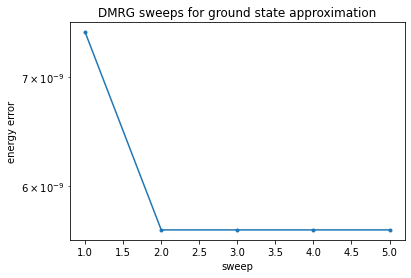

In [46]:
# convergence plot
plt.semilogy(range(1, numsweeps+1), abs((en_sweeps - en_ref)/en_ref), '.-')
plt.xlabel("sweep")
plt.ylabel("energy error")
plt.title("DMRG sweeps for ground state approximation")
plt.show()

In [47]:
# alternative way to compute energy expectation value
operator_average(Hising, ψdmrg)

-17.981355507887873

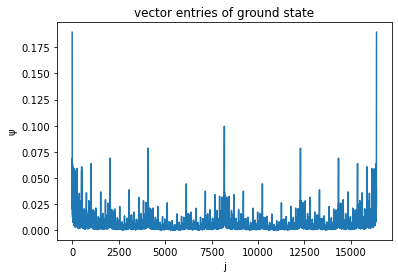

In [48]:
# show vector entries of ground state (although not very insightful)
plt.plot(ψdmrg.as_vector())
plt.xlabel("j")
plt.ylabel("ψ")
plt.title("vector entries of ground state")
plt.show()

## TEBD algorithm

In [49]:
def tebd_step(psi:MPS, U, tol=1e-5):
    """
    Single step of the TEBD algorithm, for time-evolving a quantum state `psi`
    via Trotter splitting.
    Each unitary matrix `U[i]` performs a time step at lattices sites (i, i+1).
    """
    for s in [0, 1]: # even or odd
        # time step for pairs (i, i+1) with i even or odd
        for i in range(s, psi.nsites-1, 2):
            Apair = merge_mps_tensor_pair(psi.A[i], psi.A[i+1])
            assert Apair.ndim == 3
            # apply U[i]
            Apair = np.tensordot(U[i], Apair, axes=(1, 0))
            psi.A[i], psi.A[i+1] = split_mps_tensor(Apair, psi.local_dim, psi.local_dim, "sqrt", tol)
    # psi has been updated in-place

In [50]:
def calculate_tebd_unitaries_imagtime(hloc, dt):
    """
    Calculate the local unitary blocks for TEBD imaginary-time evolution.
    """
    return [expm(-dt*h) for h in hloc]

In [51]:
def calculate_tebd_unitaries_realtime(hloc, dt):
    """
    Calculate the local unitary blocks for TEBD real-time evolution.
    """
    return [expm(-1j*dt*h) for h in hloc]

## Example run of TEBD for ground state approximation

In [52]:
hloc = construct_ising_hamiltonian_local_terms(J, g, L)

In [53]:
Uloc_imag = calculate_tebd_unitaries_imagtime(hloc, 0.1)

In [54]:
# show dimensions
[U.shape for U in Uloc_imag]

[(4, 4),
 (4, 4),
 (4, 4),
 (4, 4),
 (4, 4),
 (4, 4),
 (4, 4),
 (4, 4),
 (4, 4),
 (4, 4),
 (4, 4),
 (4, 4),
 (4, 4)]

In [55]:
# to-be optimized quantum state as MPS
ψtebd = MPS(2, [1] + (L-1)*[5] + [1], fill="random real")
ψtebd.orthonormalize("left");

In [56]:
ψtebd.local_dim

2

In [57]:
ψtebd.bond_dims

[1, 2, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1]

In [58]:
# run TEBD
numsteps = 100
en_iter_tebd = np.zeros(numsteps)
for n in range(numsteps):
    tebd_step(ψtebd, Uloc_imag)
    # re-normalize
    ψtebd.orthonormalize("left")
    en_iter_tebd[n] = operator_average(Hising, ψtebd)

In [59]:
# bond dimensions after optimization
ψtebd.bond_dims

[1, 2, 4, 8, 10, 10, 10, 10, 9, 8, 6, 4, 4, 2, 1]

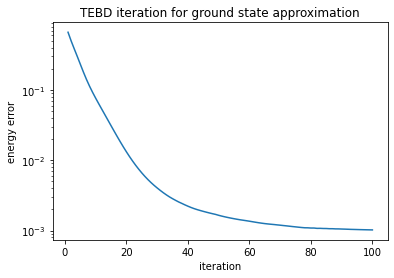

In [60]:
# convergence plot
plt.semilogy(range(1, numsteps+1), abs((en_iter_tebd - en_ref)/en_ref))
plt.xlabel("iteration")
plt.ylabel("energy error")
plt.title("TEBD iteration for ground state approximation")
plt.show()

## Example run of TEBD for real time evolution

In [61]:
# initial quantum state as MPS
ψ0 = MPS(2, [1] + (L-1)*[5] + [1], fill="random real")
ψ0.orthonormalize("left");

In [62]:
tmax = 2

In [63]:
# reference time-evolved state
ψt_ref = scila.expm_multiply(-1j*tmax*Hising_sparse, ψ0.as_vector())

In [64]:
# real-time evolution via TEBD for different time steps
# virtual bond dimensions are expected to increase quite rapidly
dt_list = [0.5**k for k in range(6)]
err_t_tebd = np.zeros(len(dt_list))
for n, dt in enumerate(dt_list):
    ψt_tebd = deepcopy(ψ0)
    Uloc = calculate_tebd_unitaries_realtime(hloc, dt)
    nsteps = round(tmax / dt)
    print("nsteps:", nsteps)
    for _ in range(nsteps):
        tebd_step(ψt_tebd, Uloc, tol=1e-7)
    # record error
    err_t_tebd[n] = np.linalg.norm(ψt_tebd.as_vector() - ψt_ref)
    print("ψt_tebd.bond_dims:", ψt_tebd.bond_dims)

nsteps: 2
ψt_tebd.bond_dims: [1, 2, 4, 8, 16, 32, 64, 40, 76, 39, 16, 8, 4, 2, 1]
nsteps: 4
ψt_tebd.bond_dims: [1, 2, 4, 8, 16, 32, 64, 95, 64, 32, 16, 8, 4, 2, 1]
nsteps: 8
ψt_tebd.bond_dims: [1, 2, 4, 8, 16, 32, 64, 98, 64, 32, 16, 8, 4, 2, 1]
nsteps: 16
ψt_tebd.bond_dims: [1, 2, 4, 8, 16, 32, 64, 91, 64, 32, 16, 8, 4, 2, 1]
nsteps: 32
ψt_tebd.bond_dims: [1, 2, 4, 8, 16, 32, 63, 81, 64, 32, 16, 8, 4, 2, 1]
nsteps: 64
ψt_tebd.bond_dims: [1, 2, 4, 8, 16, 32, 60, 72, 62, 32, 16, 8, 4, 2, 1]


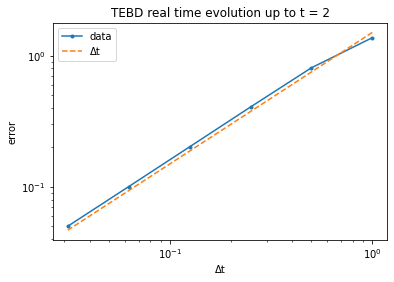

In [65]:
# convergence plot
plt.loglog(dt_list, err_t_tebd, '.-', label="data")
# dashed line shows first order scaling from Trotter splitting;
# order can be improved, e.g., via Strang splitting, almost without increase of computational cost
plt.loglog(dt_list, 1.5*np.array(dt_list), '--', label="Δt")
plt.xlabel("Δt")
plt.ylabel("error")
plt.legend()
plt.title("TEBD real time evolution up to t = {}".format(tmax))
plt.show()